# Prática 3

***Aprendizado Dinâmico***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**

Considere as duas bases de dados a seguir

- Dados de fechamento do papel PETR4 de um período de março a julho de 2020 no arquivo PETR4.csv.

- Dados de casos confirmados para COVID-19 no estado de SP.


Nesta prática, aplicaremos os conhecimentos adquiridos na Aula 3 a esses dados, a saber:

- Função de autocorrelação

- Função de autocorrelação parcial

- Repetir a modelagem para os dados de PETR4 visto em aula.

- Para os dados de COVID-19: Um modelo ARIMA sazonal.

**1. Carregue as bibliotecas**

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [19]:
def ts_train_test_split(ts, train_size):
    """ Separa a série em conjunto de treino e teste """
    cut = int(len(ts) * train_size)
    return ts[:cut+1], ts[cut:]

In [20]:
def plot_ts_prediction(X_train, X_test, X_pred, conf_interval, title):
    """ Exibe gráfico das séries de treino, teste e predição """
    X_pred = pd.Series(X_pred, index=X_test.index)
    upper_conf = pd.Series(conf_interval[:, 1], index=X_test.index)
    lower_conf = pd.Series(conf_interval[:, 0], index=X_test.index)
    
    plt.subplots(figsize=(20, 8))
    plt.plot(X_train, color="blue", label="Train")
    plt.plot(X_test, color='orange', label="Test")
    plt.plot(X_pred, color='darkgreen', ls="--", label="Prediction")
    plt.fill_between(X_test.index, lower_conf, upper_conf, color='k', alpha=.15)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()


In [21]:
def plot_autocorr(ts, lags, title):
    """ Exibe gráfico de Autocorrelação e Autocorrelação Parcial da Série """
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 5))
    
    for ax in axes:
        # define os limites de -1 e 1 para o eixo y com folga de 0.1
        ax.set_ylim(bottom=-1.1, top=1.1)
        
        # plota linha constante horizontal no eixo y em 0.5 para referencia 
        ax.axhline(y=0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")
        ax.axhline(y=-0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")

    plot_acf(ts, lags=lags, title=f"{title} (ACF)", ax=axes[0])
    plot_pacf(ts, lags=lags, title=f"{title} (PACF)", ax=axes[1])

    plt.show()

In [22]:
def plot_decomposition(ts, model, title):
    """ Exibe gráfico de Decomposição Sazonal """
    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(20, 8))

    components = seasonal_decompose(ts, model=model)
    
    sns.lineplot(x=ts.index, y=components.observed, ax=axes[0])
    axes[0].set(ylabel="Observed")
    
    sns.lineplot(x=ts.index, y=components.trend, ax=axes[1])
    axes[1].set(ylabel="Trend")
    
    sns.lineplot(x=ts.index, y=components.seasonal, ax=axes[2])
    axes[2].set(ylabel="Seasonal")
    
    sns.scatterplot(x=ts.index, y=components.resid, ax=axes[3])
    sns.lineplot(x=ts.index, y=[0 for _ in components.resid], ax=axes[3], color="gray")
    axes[3].set(ylabel="Residual")
    
    axes[0].set_title(title)
    
    plt.show()

**2. Faça a leitura dos dados de PETR4 em df1 e de COVID-19 no estado de SP em df2. Para os dados PETR4 usaremos a variável Close e para os dados de COVID-19 usaremos a variável confirmed. Complete as bases de dados usando reindex e fillna.**

In [23]:
petr4 = pd.read_csv("PETR4.csv", index_col='Date', parse_dates=True)
petr4 = petr4.reindex(
    labels=pd.date_range(
        start=petr4.index.min(),
        end=petr4.index.max(),
        freq='B' # business day frequency
    ),
    method='ffill' # propagate last valid observation forward to next valid
)

In [24]:
covid19 = pd.read_csv("covidSP.csv", index_col='date', parse_dates=True)
covid19 = covid19.reindex(
    labels=pd.date_range(
        start=covid19.index.min(),
        end=covid19.index.max(),
        freq='D' # calendar day frequency
    ),
    fill_value=0
)

In [25]:
petr4.head()

,Open,High,Low,Close,Adj Close,Volume
2020-03-18,11.79,12.27,10.87,11.29,11.289389,162515200
2020-03-19,11.07,13.07,10.85,12.21,12.209339,157065200
2020-03-20,13.11,13.50,11.83,12.00,11.999351,149029900
2020-03-23,12.11,12.18,11.28,11.50,11.499378,107092400
2020-03-24,12.57,13.54,12.28,13.25,13.249283,114259200


In [26]:
covid19.head()

,confirmed,deaths
2020-02-26,0,0
2020-02-27,0,0
2020-02-28,1,0
2020-02-29,0,0
2020-03-01,0,0


**3. Verifique graficamente se os dados foram lidos de forma correta.**

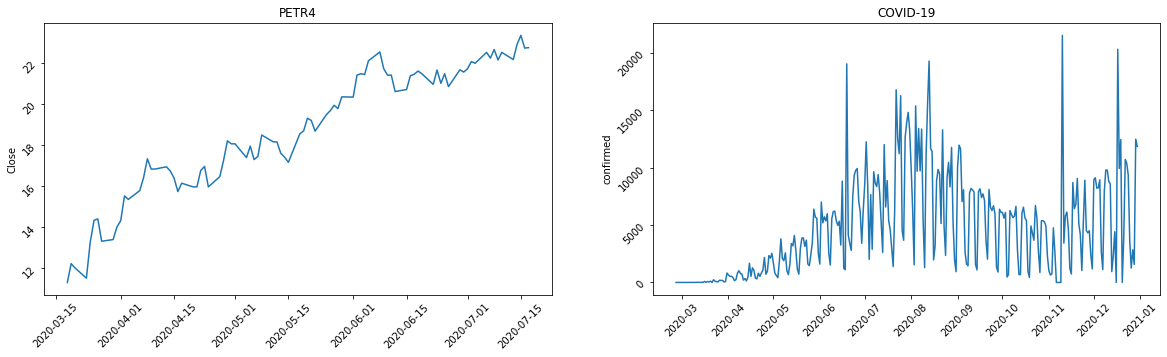

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 5))

sns.lineplot(data=petr4, x=petr4.index, y="Close", ax=axes[0])
axes[0].tick_params(rotation=45)
axes[0].set_title("PETR4")

sns.lineplot(data=covid19, x=covid19.index, y="confirmed", ax=axes[1])
axes[1].tick_params(rotation=45)
axes[1].set_title("COVID-19")

plt.show()

**4. Obtenha os gráficos de autocorrelação e autocorrelação parcial para ambas as aplicações. Que características você observa nesses gráficos? Que modelo sugeriria com base nos correlogramas?**

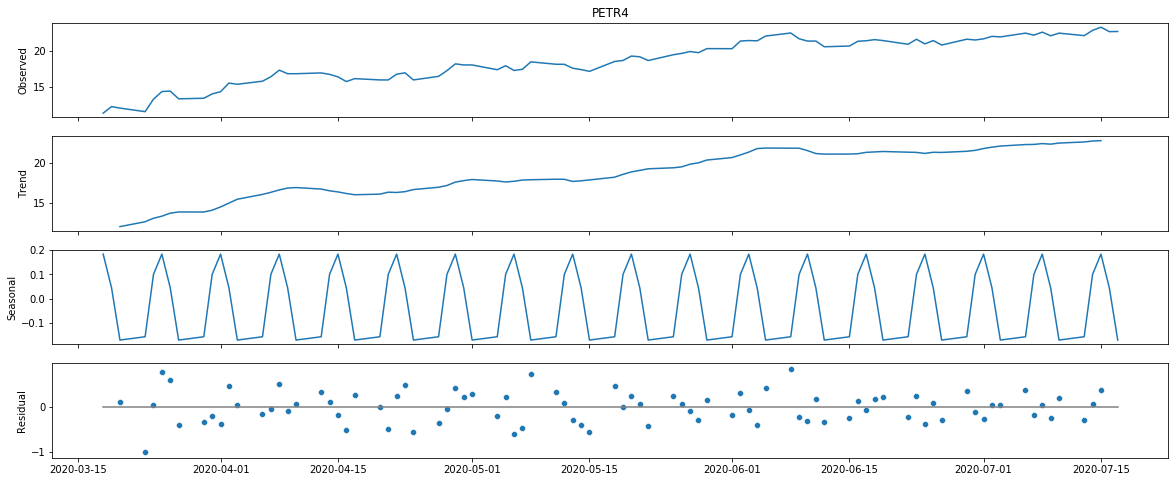

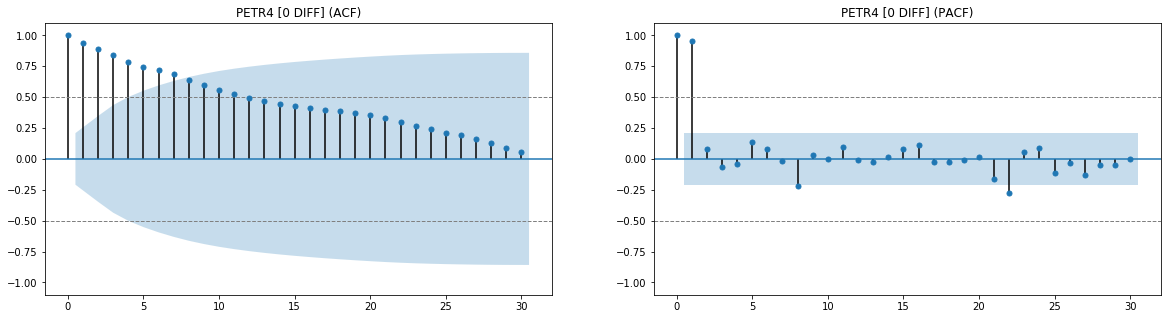

A série requer uma diferenciação de ordem 1 para atingir a estacionariedade


In [11]:
ts = petr4["Close"]
plot_decomposition(ts, "additive", "PETR4")
plot_autocorr(ts, 30, "PETR4 [0 DIFF]")
print(f"A série requer uma diferenciação de ordem {ndiffs(ts, test='adf')} para atingir a estacionariedade")

### Observações
**SD**:
- Existe uma componente de tendencia indicando uma série não estacionária
- Existe uma componente de sazonalidade indicando um período igual a 7

**ACF e PACF**:
- Existe uma correlação positiva e significativa acima de 0.5 para atrasos menores que 7 (ACF)
- Existe uma correlação positiva e significativa acima de 0.5 para atraso igual a 1 (PACF)

### Recomendação
- Considerando que a série não é estacionária e desconsiderando sazonalidade (Exercicio 7): ARIMA

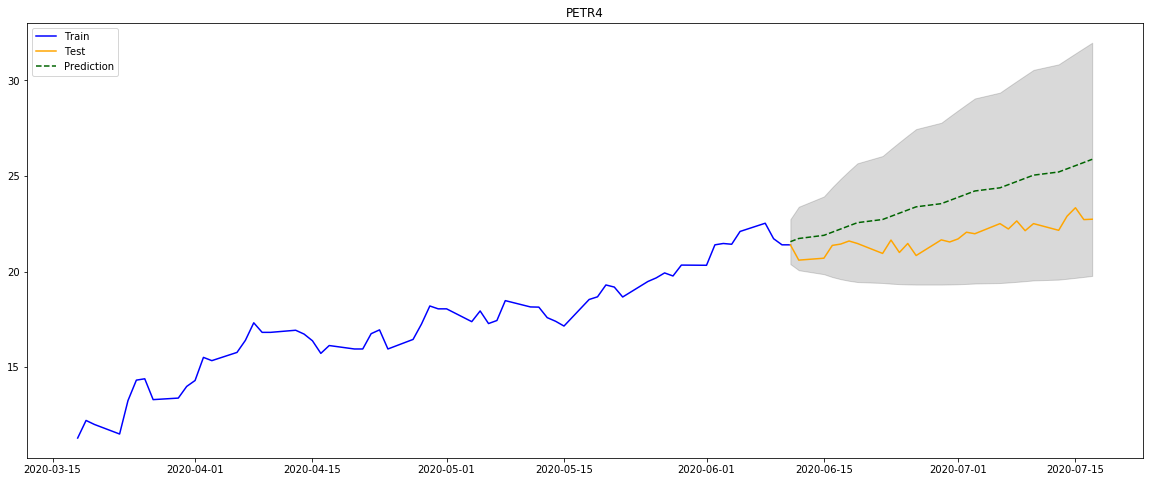

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -55.318
Date:                Sun, 01 Aug 2021   AIC                            114.637
Time:                        17:45:37   BIC                            118.858
Sample:                             0   HQIC                           116.291
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1657      0.078      2.113      0.035       0.012       0.319
sigma2         0.3591      0.072      4.995      0.000       0.218       0.500
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.81   Prob(JB):                         0.62
Heteroskedasticity (H):               0.60   Skew:                             0.27
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# Separa conjunto de treino e teste
X_train, X_test = ts_train_test_split(ts, train_size=0.7)

# Encontra o melhor modelo
petr4_model = auto_arima(
    y=X_train,
    stationary=False,  # existe indicios de estacionaridade?
    test='adf',       # teste de estacionariedade: 'adf', 'kpss', 'pp'
    information_criterion='aic', # criterio de seleção do melhor modelo: 'aic', 'bic', 'hqic', 'oob'
    trace=False,      # exibir resultados intermediarios?
    error_action='ignore',   # ignora hyperparametros que nao ajustam bem
    suppress_warnings=True,  # ignora erros de nao convergencia
    stepwise=True,            # usar o método stepwise (overfitting-prone)?
    n_jobs=3
)

# Realiza predição do modelo
X_pred, conf_interval = petr4_model.predict(n_periods=len(X_test), return_conf_int=True)


# Exibe o gráfico da predição
plot_ts_prediction(X_train, X_test, X_pred, conf_interval, "PETR4")

# Exibe detalhes do melhor modelo encontrado
petr4_model.summary()

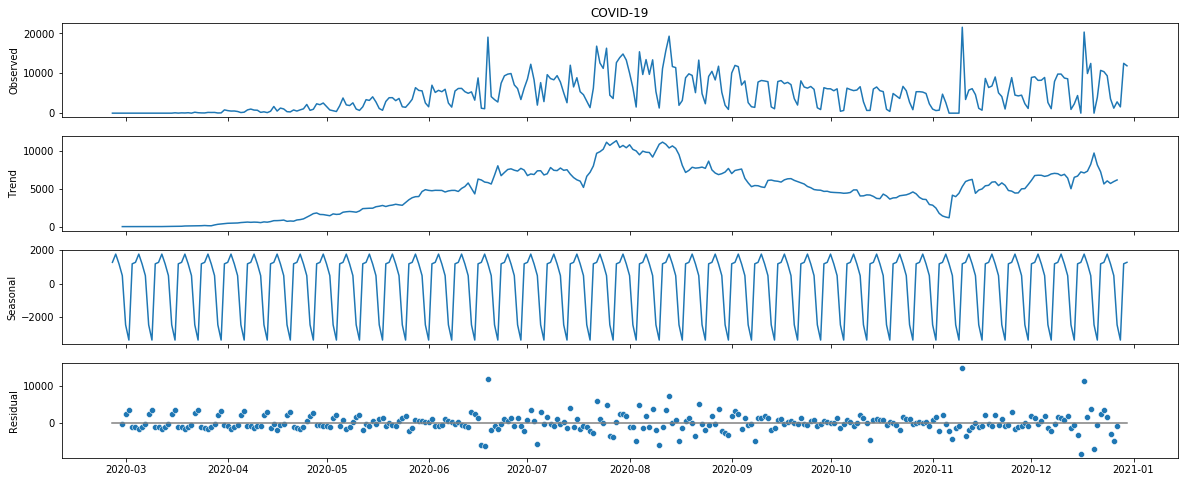

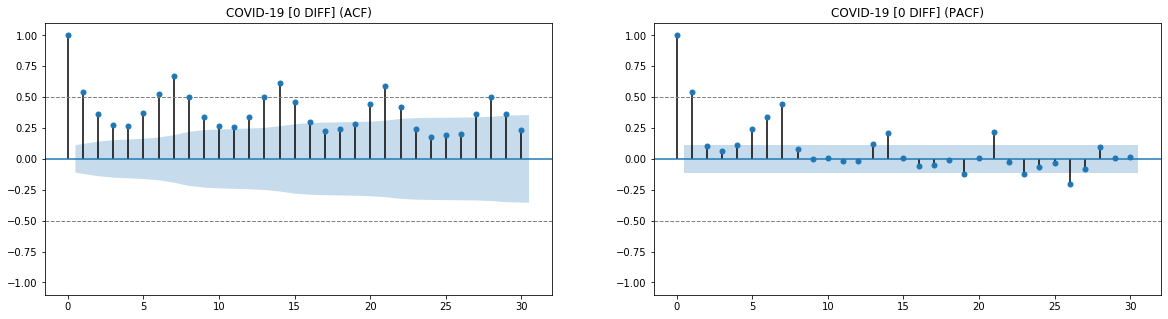

A série requer uma diferenciação de ordem 1 para atingir a estacionariedade


In [13]:
# Sazonalidade multipliticativa não deve ser usada quando valores <=0 existem
ts = covid19["confirmed"]
plot_decomposition(ts, "additive", "COVID-19") 
plot_autocorr(ts, 30, "COVID-19 [0 DIFF]")
print(f"A série requer uma diferenciação de ordem {ndiffs(ts, test='adf')} para atingir a estacionariedade")

### Observações
**SD**:
- Existe uma componente de tendencia variando ao longo do tempo indicando uma série não estacionária
- Existe uma componente de sazonalidade indicando um período igual a 7

**ACF e PACF**:
- Existe uma correlação positiva acima de 0.5 para atraso igual a 1
- Existe picos correlação positiva acima de 0.5 em intervalos de período igual a 7 reforçando o indício de sazonalidade encontrado em SD

### Recomendação
- Considerando que a série não é estacionária e desconsiderando sazonalidade (Exercicio 7): ARIMA

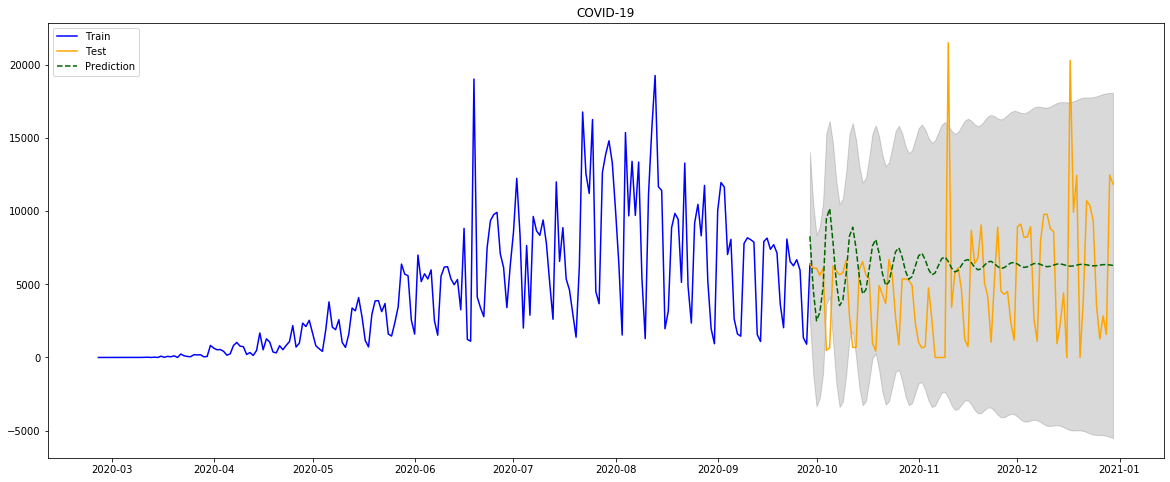

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(7, 1, 0)   Log Likelihood               -2894.422
Date:                Sun, 01 Aug 2021   AIC                           5804.844
Time:                        17:45:54   BIC                           5834.685
Sample:                             0   HQIC                          5816.776
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8271      0.049    -17.017      0.000      -0.922      -0.732
ar.L2         -0.8044      0.052    -15.606      0.000      -0.905      -0.703
ar.L3         -0.8032      0.051    -15.635      0.000      -0.904      -0.703
ar.L4         -0.8088      0.049    -16.449      0.000      -0.905      -0.712
ar.L5         -0.7360      0.052    -14.193      0.000      -0.838      -0.634
ar.L6         -0.5431      0.051    -10.565      0.000      -0.644      -0.442
ar.L7         -0.0967      0.047     -2.055      0.040      -0.189      -0.004
sigma2      8.638e+06   3.27e+05     26.456      0.000       8e+06    9.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1387.43
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              18.17   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Separa conjunto de treino e teste
X_train, X_test = ts_train_test_split(ts, train_size=0.7)

# Encontra o melhor modelo
covid19_model = auto_arima(
    y=covid19["confirmed"],
    max_p=10,
    max_d=10,
    max_q=10,
    stationary=False,  # existe indicios de estacionaridade?
    test='adf',       # teste de estacionariedade: 'adf', 'kpss', 'pp'
    information_criterion='aic', # criterio de seleção do melhor modelo: 'aic', 'bic', 'hqic', 'oob'
    trace=False,      # exibir resultados intermediarios?
    error_action='ignore',   # ignora hyperparametros que nao ajustam bem
    suppress_warnings=True,  # ignora erros de nao convergencia
    stepwise=True,            # usar o método stepwise (overfitting-prone)?
    n_jobs=3
)

# Realiza predição do modelo
X_pred, conf_interval = covid19_model.predict(n_periods=len(X_test), return_conf_int=True)


# Exibe o gráfico da predição
plot_ts_prediction(X_train, X_test, X_pred, conf_interval, "COVID-19")

# Exibe detalhes do melhor modelo encontrado
covid19_model.summary()

**5. Repita os gráficos de autocorrelação e autocorrelação parcial para a primeira diferença de cada aplicação. O que você pode concluir?**

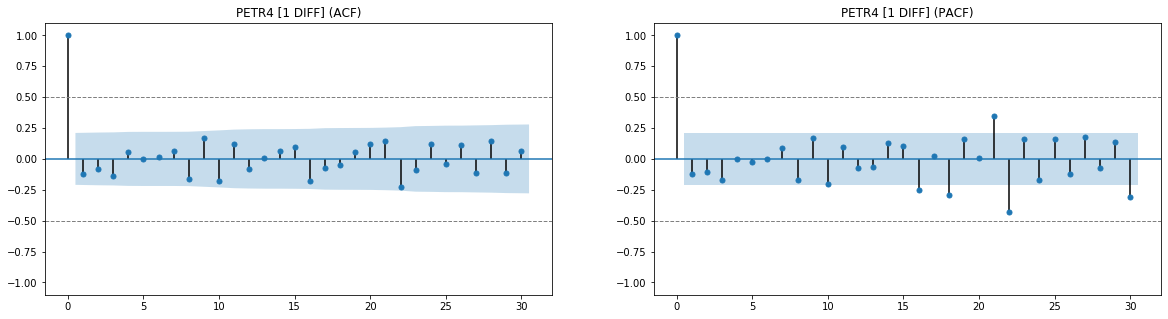

In [15]:
ts = diff(petr4["Close"])
plot_autocorr(ts, 30, "PETR4 [1 DIFF]")

### Observações
- Não existe correlação forte e significante para nenhum atraso

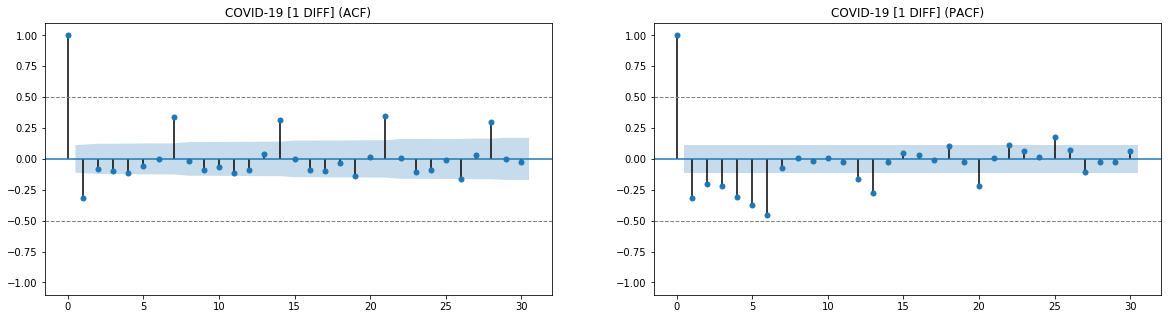

In [16]:
ts = diff(covid19["confirmed"])
plot_autocorr(ts, 30, "COVID-19 [1 DIFF]")

### Observações
- PACF: Exibe correlações fracas mas significante para atrasos menores que 7 indicando uma componente autoregressiva
- ACF: Exibe correlações fracas mas significante para intervalos de atraso de periodo 7 indicando uma componente de média movel

**6. Para os dados de PETR4, refaça a modelagem vista em aula.**

Realizado no Exercício 4

**7. Desafio: Ainda não vimos o modelo SARIMA, mas já sabemos que a série de COVID-19 tem sazonalidade. Como os dados de COVID-19 apresentam sazonalidade, vamos arriscar no tema da próxima aula? Altere seasonal para True e escolha o melhor modelo entre os SARIMA propostos. Discutiremos com detalhes este modelo na Aula 4.**

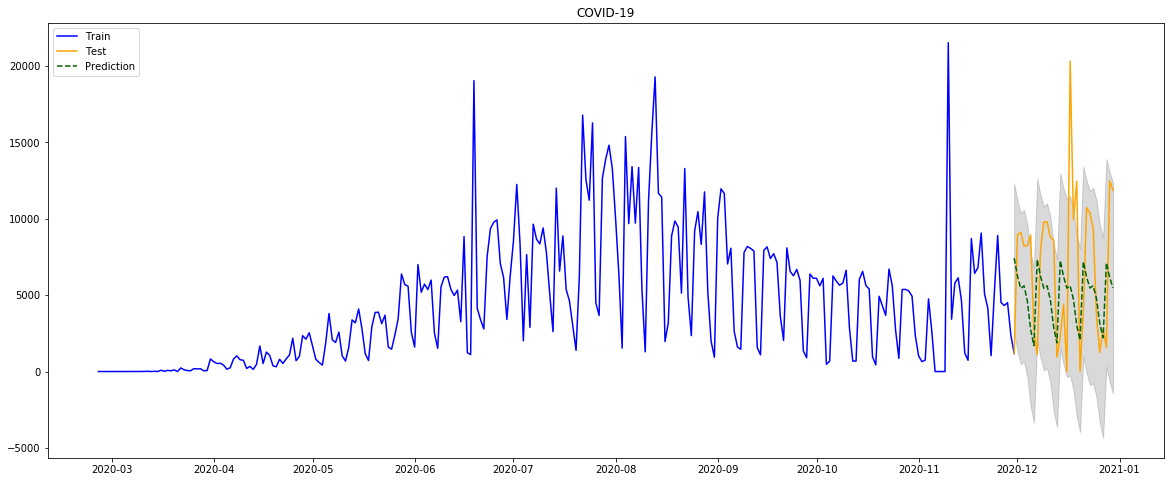

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  279
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2572.100
Date:                           Tue, 03 Aug 2021   AIC                           5152.201
Time:                                   21:31:54   BIC                           5166.711
Sample:                                        0   HQIC                          5158.022
                                           - 279                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8961      0.027    -33.144      0.000      -0.949      -0.843
ar.S.L7        0.9549      0.040     23.736      0.000       0.876       1.034
ma.S.L7       -0.7378      0.079     -9.396      0.000      -0.892      -0.584
sigma2      6.236e+06   2.19e+05     28.534      0.000    5.81e+06    6.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              3703.06
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              15.42   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Separa conjunto de treino e teste
ts = covid19["confirmed"]
X_train, X_test = ts_train_test_split(ts, train_size=0.9)

# Encontra o melhor modelo
covid19_sazonal_model = auto_arima(
    y=X_train,
    max_p=10,
    max_d=10,
    max_q=10,
    seasonal=True,    # existe indicios de sazonalidade?
    m=7,              # periodo da sazonalidade
    stationary=False,  # existe indicios de estacionaridade?
    test='adf',       # teste de estacionariedade: 'adf', 'kpss', 'pp'
    information_criterion='aic', # criterio de seleção do melhor modelo: 'aic', 'bic', 'hqic', 'oob'
    trace=False,      # exibir resultados intermediarios?
    error_action='ignore',   # ignora hyperparametros que nao ajustam bem
    suppress_warnings=True,  # ignora erros de nao convergencia
    stepwise=True,            # usar o método stepwise (overfitting-prone)?
    n_jobs=3
)

# Realiza predição do modelo
X_pred, conf_interval = covid19_sazonal_model.predict(n_periods=len(X_test), return_conf_int=True)


# Exibe o gráfico da predição
plot_ts_prediction(X_train, X_test, X_pred, conf_interval, "COVID-19")

# Exibe detalhes do melhor modelo encontrado
covid19_sazonal_model.summary()